In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Load dataset
with open("train_val_test_1.pkl", "rb") as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

print("Data successfully loaded!")


Data successfully loaded!


In [2]:
object_columns = X_train.select_dtypes(include=["object"]).columns.tolist()
object_columns

[]

In [3]:
X_train.shape

(930382, 59)

In [4]:

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
import time
import pandas as pd

# Impute missing values
imputer = SimpleImputer(strategy="median")
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

smote = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

print("SMOTE done:")
print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE: ", pd.Series(y_train_resampled).value_counts().to_dict())

xgb_model = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda",
    eval_metric=["auc", "aucpr", "error", "logloss"],
    learning_rate=0.05,
    n_estimators=500,
    max_depth=6,
    min_child_weight=3,
    gamma=0.2,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.3,
    reg_lambda=1.5,
    random_state=1,
    n_jobs=1,
    early_stopping_rounds=30
)


eval_set = [(X_val, y_val)]
start_time = time.time()
xgb_model.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=eval_set,
    verbose=True
)
print(f"Model training complete. Time: {time.time() - start_time:.2f} seconds")

y_val_pred = xgb_model.predict(X_val)
y_val_proba = xgb_model.predict_proba(X_val)[:, 1]

print("AUC on validation set:", roc_auc_score(y_val, y_val_proba))
print("Classification Report:\n", classification_report(y_val, y_val_pred))


SMOTE done:
Before SMOTE: {1: 760964, 0: 169418}
After SMOTE:  {1: 760964, 0: 760964}


C:\Users\xinto\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:41:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
C:\Users\xinto\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [02:41:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-auc:0.58985	validation_0-aucpr:0.85605	validation_0-error:0.19443	validation_0-logloss:0.68018
[1]	validation_0-auc:0.59677	validation_0-aucpr:0.86006	validation_0-error:0.19443	validation_0-logloss:0.66867
[2]	validation_0-auc:0.60743	validation_0-aucpr:0.86354	validation_0-error:0.19889	validation_0-logloss:0.66103
[3]	validation_0-auc:0.60560	validation_0-aucpr:0.86309	validation_0-error:0.19443	validation_0-logloss:0.65047
[4]	validation_0-auc:0.60935	validation_0-aucpr:0.86366	validation_0-error:0.19676	validation_0-logloss:0.64291
[5]	validation_0-auc:0.61637	validation_0-aucpr:0.86610	validation_0-error:0.19647	validation_0-logloss:0.63380
[6]	validation_0-auc:0.61334	validation_0-aucpr:0.86478	validation_0-error:0.19647	validation_0-logloss:0.62789
[7]	validation_0-auc:0.61459	validation_0-aucpr:0.86566	validation_0-error:0.19908	validation_0-logloss:0.62106
[8]	validation_0-auc:0.61525	validation_0-aucpr:0.86607	validation_0-error:0.19607	validation_0-logloss:

In [5]:
# Make predictions
y_pred = xgb_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7809


In [6]:
# 1. Check class distribution
class_dist = y_test.value_counts(normalize=True) * 100
print(f"Class distribution: {class_dist.to_dict()}")

# 2. Check performance by class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# 3. Calculate class-specific accuracy
class_0_acc = cm[0,0] / (cm[0,0] + cm[0,1])
class_1_acc = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Class 0 accuracy: {class_0_acc:.2f}")
print(f"Class 1 accuracy: {class_1_acc:.2f}")

# 4. Check model complexity (corrected)
if hasattr(xgb_model, 'get_booster'):
    # sklearn API
    num_trees = len(xgb_model.get_booster().get_dump())
    print(f"XGBoost model has {num_trees} trees")
elif hasattr(xgb_model, 'n_estimators'):
    # sklearn API alternative
    print(f"XGBoost model has {xgb_model.n_estimators} trees")
elif hasattr(xgb_model, 'get_dump'):
    # Native Booster object
    num_trees = len(xgb_model.get_dump())
    print(f"XGBoost model has {num_trees} trees")
else:
    print("Couldn't determine number of trees - check model type")

Class distribution: {1: 77.85770330402632, 0: 22.142296695973688}
Confusion Matrix:
[[  3248  79155]
 [  2385 287364]]
Class 0 accuracy: 0.04
Class 1 accuracy: 0.99
XGBoost model has 500 trees


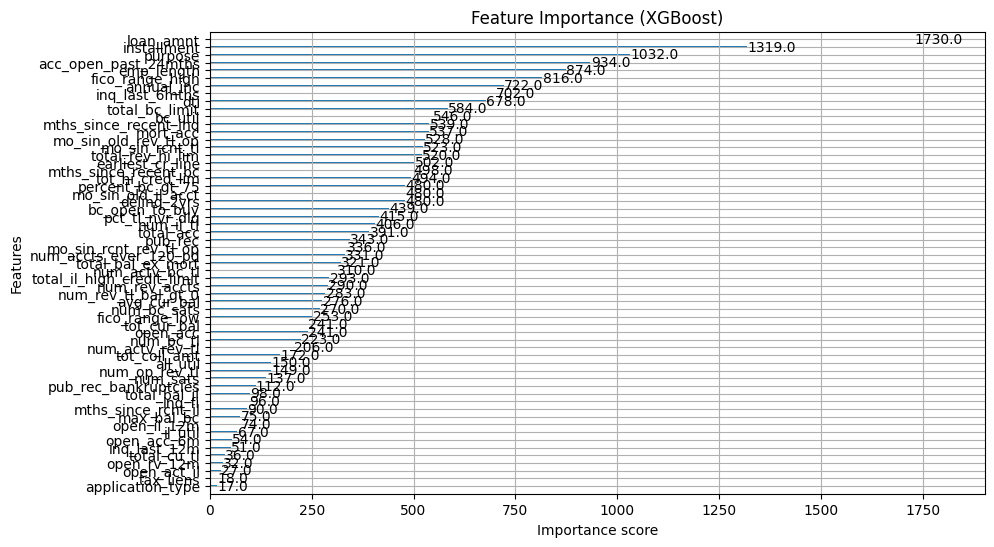

In [7]:
# Feature Importance
import matplotlib.pyplot as plt

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type="weight", ax=ax)
plt.title("Feature Importance (XGBoost)")
plt.show()

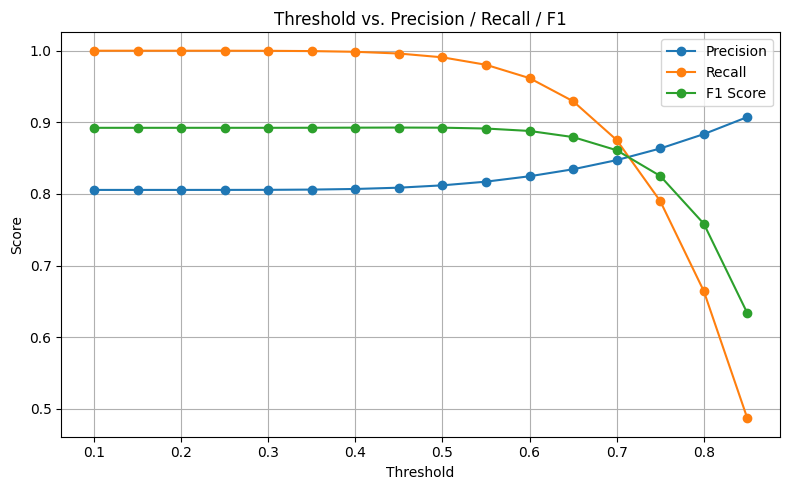

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.9, 0.05)

precisions = []
recalls = []
f1s = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba > thresh).astype(int)
    precisions.append(precision_score(y_val, y_pred_thresh))
    recalls.append(recall_score(y_val, y_pred_thresh))
    f1s.append(f1_score(y_val, y_pred_thresh))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision", marker='o')
plt.plot(thresholds, recalls, label="Recall", marker='o')
plt.plot(thresholds, f1s, label="F1 Score", marker='o')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs. Precision / Recall / F1")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [9]:
threshold = 0.68  
y_val_adjusted = (y_val_proba > threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(f"Classification Report at threshold {threshold}:")
print(classification_report(y_val, y_val_adjusted))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_adjusted))



Classification Report at threshold 0.68:
              precision    recall  f1-score   support

           0       0.42      0.30      0.35     72357
           1       0.84      0.90      0.87    299795

    accuracy                           0.78    372152
   macro avg       0.63      0.60      0.61    372152
weighted avg       0.76      0.78      0.77    372152

Confusion Matrix:
[[ 21609  50748]
 [ 29929 269866]]
